identification of Dopimanergic Neurons in Substantia Nigra using ASAP CRN scnRNA cohort data.


In [1]:
import sys, subprocess, importlib, warnings, math, os, pandas as pd, gc
from pathlib import Path

def setup_environment():
    """Configure logging, warnings, pandas options, and auto-install core packages."""

    def import_or_install(pkg, name=None):
        try:
            return importlib.import_module(name or pkg)
        except ImportError:
            print(f"{pkg} not found. Installing...")
            subprocess.run([sys.executable, "-m", "pip", "install", pkg], check=True)
            return importlib.import_module(name or pkg)

    env = {
        "pd": pd,
        "np": import_or_install("numpy"),
        "plt": import_or_install("matplotlib.pyplot", "matplotlib.pyplot"),
        "sns": import_or_install("seaborn"),
        "Image": import_or_install("PIL.Image", "PIL.Image"),
        "sc": import_or_install("scanpy")
        # # andy's hacked in stuff
        # "scvi": import_or_install("
    }
    pd.set_option("display.max_columns", None)
    pd.set_option("display.width", 1200)
    
    print("Environment ready.")
    return env

In [ ]:
##
# pip3 install -U scvi-tools[cuda]  # gets jax and jaxlib, updates cuda 
# pip3 install -U scib-metrics
#
# 
#

In [2]:
env = setup_environment()
pd, np, plt, sns, Image, sc  = (
    env["pd"], env["np"], env["plt"], env["sns"],
    env["Image"], env["sc"]
)

Environment ready.


## 1. Workspace Setup

### 1.1 Set dataset paths
In this example, we are working with the **PMDBS single‑cell RNA‑seq cohort** dataset:

- **Workflow** → `pmdbs_sc_rnaseq`  
- **Team** → `cohort`  
- **Source** → `pmdbs`  
- **Type** → `sc-rnaseq`  

These components are combined to construct the bucket and dataset names.  
We then set the path to the **cohort analysis outputs** and preview the available files.


In [3]:
#set general folder paths
HOME = Path.home()
WS_ROOT = HOME / "workspace"
DATA_DIR = WS_ROOT / "Data"
WS_FILES = WS_ROOT / "ws_files"

if not WS_ROOT.exists():
    print(f"{WS_ROOT} doesn't exist. We need to remount our resources")
    !wb resource mount    

print("Home directory:     ", HOME)
print("Workspace root:     ", WS_ROOT)
print("Data directory:     ", DATA_DIR)
print("ws_files directory: ", WS_FILES)

print("\nContents of workspace root:")
for p in WS_ROOT.glob("*"):
    print(" -", p.name, "/" if p.is_dir() else "")

Home directory:      /home/jupyter
Workspace root:      /home/jupyter/workspace
Data directory:      /home/jupyter/workspace/Data
ws_files directory:  /home/jupyter/workspace/ws_files

Contents of workspace root:
 - Documentation /
 - 01_PMDBS_scRNAseq /
 - 02_PMDBS_bulkRNAseq /
 - 05_Other_Datasets /
 - 03_PMDBS_Spatial /
 - nbs /
 - 04_Mouse_Spatial /


In [4]:
## Build and set path to desired dataset

DATASETS_PATH = WS_ROOT / "01_PMDBS_scRNAseq"

workflow       = "pmdbs_sc_rnaseq"
dataset_team   = "cohort"
dataset_source = "pmdbs"
dataset_type   = "sc-rnaseq"

bucket_name  = f"asap-curated-{dataset_team}-{dataset_source}-{dataset_type}"
dataset_name = f"asap-{dataset_team}-{dataset_source}-{dataset_type}"

dataset_path = DATASETS_PATH / bucket_name / workflow
print("Dataset Path:", dataset_path)

# Build the folder path to the cohort analysis directory
cohort_analysis_path = dataset_path / "cohort_analysis"

# Preview the directory contents
print("Contents of cohort_analysis:")
!ls {cohort_analysis_path}

Dataset Path: /home/jupyter/workspace/01_PMDBS_scRNAseq/asap-curated-cohort-pmdbs-sc-rnaseq/pmdbs_sc_rnaseq
Contents of cohort_analysis:
ls: cannot access '/home/jupyter/workspace/01_PMDBS_scRNAseq/asap-curated-cohort-pmdbs-sc-rnaseq/pmdbs_sc_rnaseq/cohort_analysis': No such file or directory


In [5]:
# Define a local path for workshop files
local_data_path = WS_FILES / "case_study_01"

# Create the directory if it doesn't already exist
if not local_data_path.exists():
    local_data_path.mkdir(parents=True)

print(f"Local data directory ready at: {local_data_path}")

Local data directory ready at: /home/jupyter/workspace/ws_files/case_study_01


### Copy Data Locally

We now bring in the curated dataset files:

- **`asap-cohort.final_metadata.csv`** → cell‑level metadata table
- **`asap-cohort.final.h5ad`** → full AnnData object containing HVG expression data and annotations  

We copy these files into our local `pilot_workshop_files` directory (if not already present) and load them into memory.

The metadata CSV is read into a Pandas dataframe, while the `.h5ad` file is loaded as an AnnData object in backed mode.

In [6]:
# Downloading obs field (cell metadata)
# Define the expected local path for the metadata file.
cell_metadata_local_path = local_data_path / f"asap-{dataset_team}.final_metadata.csv"\

# Check if the metadata file already exists locally.
if not cell_metadata_local_path.exists():
    # Construct the original path where the metadata file is stored.
    cell_metadata_og_path = cohort_analysis_path / f"asap-{dataset_team}.final_metadata.csv"

    # Use a shell command (`cp`) to copy the file from the original location
    # into the local workshop_files directory for analysis.
    !cp {cell_metadata_og_path} {cell_metadata_local_path}

In [7]:
# Downloading the anndata object
# Define the expected local path
adata_local_path = local_data_path / f"asap-{dataset_team}.final.h5ad"

# Check if the adata file already exists locally.
if not adata_local_path.exists():
    # Construct the original path where the metadata file is stored.
    adata_cell_metadata_og_path = cohort_analysis_path / f"asap-{dataset_team}.final.h5ad"

    # Use a shell command (`cp`) to copy the file from the original location
    # into the local workshop_files directory for analysis.
    !cp {adata_cell_metadata_og_path} {adata_local_path}

# load the adata object
adata = sc.read_h5ad(adata_local_path, backed="r")
adata

AnnData object with n_obs × n_vars = 3046127 × 3000 backed at '/home/jupyter/workspace/ws_files/case_study_01/asap-cohort.final.h5ad'
    obs: 'background_fraction', 'cell_probability', 'cell_size', 'droplet_efficiency', 'n_genes_by_counts', 'total_counts', 'total_counts_rb', 'pct_counts_rb', 'total_counts_mt', 'pct_counts_mt', 'doublet_score', 'sample', 'batch', 'team', 'dataset', 'batch_id', 'S_score', 'G2M_score', 'phase', 'cell_type', 'phenotype', 'rho', 'prob', 'class_name', 'subclass_name', 'supertype_name', '_scvi_batch', '_scvi_labels', 'C_scANVI', 'leiden_res_0.05', 'leiden_res_0.10', 'leiden_res_0.20', 'leiden_res_0.40'
    var: 'feature_type', 'genome', 'gene_id', 'mt', 'rb'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'estimator', 'fraction_data_used_for_testing', 'learning_curve_learning_rate_epoch', 'learning_curve_test_epoch', 'learning_curve_train_epoch', 'leiden_res_0.05', 'leiden_res_0.10', 'leiden_res_0.20', 'leiden_res_0.40', 'log1p', 'neighbors', 'pca', 'scrublet',

### Metadata Access & Integration 

In [8]:
#Define metadata folder path
ds_metadata_path = WS_ROOT / "release_resources/cohort-pmdbs-sc-rnaseq/metadata"

#preview contents
!ls {ds_metadata_path} 

ASSAY_RNAseq.csv  collection_version  PMDBS.csv     STUDY.csv
cde_version	  CONDITION.csv       PROTOCOL.csv  SUBJECT.csv
CLINPATH.csv	  DATA.csv	      SAMPLE.csv


In [9]:
# Sample-level metadata
SAMPLE = pd.read_csv(ds_metadata_path / "SAMPLE.csv", index_col=0)
# Subject-level metadata
SUBJECT = pd.read_csv(ds_metadata_path / "SUBJECT.csv", index_col=0)
#  Brain-sample metadata
PMDBS = pd.read_csv(ds_metadata_path / "PMDBS.csv", index_col=0)
# Experimental condition metadata
CONDITION = pd.read_csv(ds_metadata_path / "CONDITION.csv", index_col=0)

# Select Relevant Columns
sample_cols = [
    "ASAP_sample_id",
    "ASAP_subject_id",
    "ASAP_team_id",
    "ASAP_dataset_id",
    "replicate",
    "condition_id",
    "age_at_collection"
]
subject_cols = [
    "ASAP_subject_id",
    "source_subject_id",
    "sex",
    "primary_diagnosis",
]
pmdbs_cols = [
    "ASAP_sample_id",
    "brain_region",
    "region_level_1",
    "region_level_2",
    "region_level_3",
]
condition_cols = [
    "condition_id",
    "intervention_name",
    "intervention_id",
    "protocol_id",
]

In [10]:
# Merge SAMPLE ↔ CONDITION using condition_id
df = pd.merge(
    SAMPLE[sample_cols], CONDITION[condition_cols], on="condition_id", how="left"
)
# Merge in SUBJECT information
df = pd.merge(df, SUBJECT[subject_cols], on="ASAP_subject_id", how="left")

# Merge in brain-region information
df = pd.merge(df, PMDBS[pmdbs_cols], on="ASAP_sample_id", how="left")

# create unique sample identifier
df["sample"] = df["ASAP_sample_id"] + "_" + df["replicate"]

In [11]:
df.head()

,ASAP_sample_id,ASAP_subject_id,ASAP_team_id,ASAP_dataset_id,replicate,condition_id,age_at_collection,intervention_name,intervention_id,protocol_id,source_subject_id,sex,primary_diagnosis,brain_region,region_level_1,region_level_2,region_level_3,sample
0,ASAP_PMBDS_000026_s001,ASAP_PMBDS_000026,TEAM_HAFLER,DS_PMDBS_0002,Rep1,Control,81.0,Case-Control,NaN,NaN,hSDG07,Female,Healthy Control,Prefrontal Cortex,Frontal lobe,Prefrontal cortex,Grey matter,ASAP_PMBDS_000026_s001_Rep1
1,ASAP_PMBDS_000026_s001,ASAP_PMBDS_000026,TEAM_HAFLER,DS_PMDBS_0002,Rep1,Control,81.0,Case-Control,NaN,NaN,hSDG07,Female,Healthy Control,Prefrontal Cortex,Frontal lobe,Prefrontal cortex,Grey matter,ASAP_PMBDS_000026_s001_Rep1
2,ASAP_PMBDS_000026_s001,ASAP_PMBDS_000026,TEAM_HAFLER,DS_PMDBS_0002,Rep1,Control,81.0,Case-Control,Control,NaN,hSDG07,Female,Healthy Control,Prefrontal Cortex,Frontal lobe,Prefrontal cortex,Grey matter,ASAP_PMBDS_000026_s001_Rep1
3,ASAP_PMBDS_000026_s001,ASAP_PMBDS_000026,TEAM_HAFLER,DS_PMDBS_0002,Rep1,Control,81.0,Case-Control,NaN,NaN,hSDG07,Female,Healthy Control,Prefrontal Cortex,Frontal lobe,Prefrontal cortex,Grey matter,ASAP_PMBDS_000026_s001_Rep1
4,ASAP_PMBDS_000027_s001,ASAP_PMBDS_000027,TEAM_HAFLER,DS_PMDBS_0002,Rep1,Control,65.0,Case-Control,NaN,NaN,hSDG13,Female,Healthy Control,Prefrontal Cortex,Frontal lobe,Prefrontal cortex,Grey matter,ASAP_PMBDS_000027_s001_Rep1


In [12]:
df.brain_region.value_counts()

brain_region
MFG                      408
Middle temporal gyrus    319
IPL                      284
ACG                      268
Prefrontal cortex        168
Putamen                  148
Amygdala                 136
Substantia nigra         136
Prefrontal Cortex         48
Name: count, dtype: int64

In [13]:
# Recode brain region to be "PFC", "MFG", "HIP", "SN", "ACG", "IPL, "AMG", "PUT"
brain_fix = {
    "Prefrontal Cortex": "PFC",
    "Middle_Frontal_Gyrus": "MFG",
    "Hippocampus": "HIP",
    "Substantia_Nigra ": "SN",
    "ACG": "ACG",
    "IPL": "IPL",
    "Middle temporal gyrus": "MTG",
    "Substantia nigra": "SN",
    "Prefrontal cortex": "PFC",
    "Amygdala": "AMG",
    "Putamen": "PUT",
}
df["brain_region"] = df["brain_region"].map(brain_fix)

In [14]:
# Map to find more course designations
brain_simple = {
    "PFC": "frontal_ctx",
    "MFG": "frontal_ctx",
    "ACG": "cingulate_ctx",
    "IPL": "parietal_ctx",
    "MTG": "temporal_ctx",
    "HIP": "subcortical",
    "AMG": "subcortical",
    "PUT": "subcortical",
    "SN": "subcortical",
}

df["brain_region_simple"] = df["brain_region"].map(brain_simple)


# Define sample to match
br_mapper_full = dict(zip(df["sample"], df["brain_region"]))
br_mapper_simple = dict(zip(df["sample"], df["brain_region"].map(brain_simple)))

# Parkinsons and control samples
condition_id_mapper = dict(zip(df["sample"], df["condition_id"]))
case_id_mapper = dict(zip(df["sample"], df["intervention_name"]))

# Detailed brain region mapper 
region_1_mapper = dict(zip(df["sample"], df["region_level_1"]))
region_2_mapper = dict(zip(df["sample"], df["region_level_2"]))

# Diagnoses
diagnoses_mapper = dict(zip(df["sample"], df["primary_diagnosis"]))

In [15]:
dataset_metadata_filen = local_data_path / "asap-cohort-dataset-metadata.csv"
df.to_csv(dataset_metadata_filen)

In [17]:
cell_metadata = adata.obs.copy()

In [18]:
# # Map samples to metadata
# adata.obs["brain_region"] = adata.obs["sample"].map(br_mapper_full)
# adata.obs["brain_region_simple"] = adata.obs["sample"].map(br_mapper_simple)
# adata.obs["case_id"] = adata.obs["sample"].map(case_id_mapper)
# adata.obs["condition_id"] = adata.obs["sample"].map(condition_id_mapper)
# adata.obs["region_level_1"] = adata.obs["sample"].map(region_1_mapper)
# adata.obs["region_level_2"] = adata.obs["sample"].map(region_2_mapper)

# Map samples to metadata
cell_metadata["brain_region"] = cell_metadata["sample"].map(br_mapper_full)
cell_metadata["brain_region_simple"] = cell_metadata["sample"].map(br_mapper_simple)
cell_metadata["case_id"] = cell_metadata["sample"].map(case_id_mapper)
cell_metadata["condition_id"] = cell_metadata["sample"].map(condition_id_mapper)
cell_metadata["region_level_1"] = cell_metadata["sample"].map(region_1_mapper)
cell_metadata["region_level_2"] = cell_metadata["sample"].map(region_2_mapper)

## Subset for Substantia Nigra + Neuronal Cells

In [21]:
# identify substantia nigra cells
sn_cells = cell_metadata["brain_region"] == "SN"
# Final boolean mask for subsetting
include = sn_cells

In [22]:
include

TCATTGTCAACAGTGG-1_ASAP_PMBDS_000038_s001_Rep1.cleaned_unfiltered.h5ad    False
ATTGGGTTCCAACACA-1_ASAP_PMBDS_000038_s001_Rep1.cleaned_unfiltered.h5ad    False
TTGAACGGTGCCTACG-1_ASAP_PMBDS_000038_s001_Rep1.cleaned_unfiltered.h5ad    False
TTCATTGAGGCCCACT-1_ASAP_PMBDS_000038_s001_Rep1.cleaned_unfiltered.h5ad    False
GTCTGTCGTCACCGCA-1_ASAP_PMBDS_000038_s001_Rep1.cleaned_unfiltered.h5ad    False
                                                                          ...  
CCGTTCATCCCGGTAG-1_ASAP_PMDBS_000438_s004_1.cleaned_unfiltered.h5ad       False
ATTGTTCTCAACTTTC-1_ASAP_PMDBS_000438_s004_1.cleaned_unfiltered.h5ad       False
TCCTCCCAGAGGCTGT-1_ASAP_PMDBS_000438_s004_1.cleaned_unfiltered.h5ad       False
TTACGCCGTAACCCGC-1_ASAP_PMDBS_000438_s004_1.cleaned_unfiltered.h5ad       False
ACTCTCGTCGCTAGCG-1_ASAP_PMDBS_000438_s004_1.cleaned_unfiltered.h5ad       False
Name: brain_region, Length: 3046127, dtype: bool

In [20]:
print(sum(include))

124704


In [23]:
# Create SN subset
sn_ad = adata[include].to_memory()
adata.file.close()  # close the original adata file

In [26]:
# 
og_obs = sn_ad.obs.copy()

new_obs = cell_metadata[include]



In [ ]:
new_obs.shape

In [32]:
cell_metadata.shape, new_obs.shape, og_obs.shape

((3046127, 39), (124704, 39), (124704, 33))

In [33]:
sn_ad.obs = new_obs

In [22]:
sn_ad.obs["condition_id"].value_counts()

condition_id
Control    71928
PD         52776
Name: count, dtype: int64

### Export SN - Subset

In [35]:
snn_samples_filename = (
    local_data_path / f"asap-{dataset_team}.sn__samples.h5ad"
)
sn_ad.write_h5ad(snn_samples_filename
                          )


/opt/conda/envs/jupyter/lib/python3.10/site-packages/anndata/_core/anndata.py:1138: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[key] = c
/opt/conda/envs/jupyter/lib/python3.10/site-packages/anndata/_core/anndata.py:1138: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[key] = c
/opt/conda/envs/jupyter/lib/python3.10/site-packages/anndata/_core/anndata.py:1138: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inst

In [37]:
new_obs

,background_fraction,cell_probability,cell_size,droplet_efficiency,n_genes_by_counts,total_counts,total_counts_rb,pct_counts_rb,total_counts_mt,pct_counts_mt,doublet_score,sample,batch,team,dataset,batch_id,S_score,G2M_score,phase,cell_type,phenotype,rho,prob,class_name,subclass_name,supertype_name,_scvi_batch,_scvi_labels,C_scANVI,leiden_res_0.05,leiden_res_0.10,leiden_res_0.20,leiden_res_0.40,brain_region,brain_region_simple,case_id,condition_id,region_level_1,region_level_2
AGCGATTCAGAATGTA-1_ASAP_PMBDS_000105_s001_1.cleaned_unfiltered.h5ad,0.000030,0.999955,14321.718750,2.374893,6935,33701,118,0.350138,152,0.451025,0.031680,ASAP_PMBDS_000105_s001_1,1,team-jakobsson,DS_PMDBS_0004,team-jakobsson_DS_PMDBS_0004_1,-0.016962,-0.063842,G1,OPC,OPC,0.9053,1.00,Non-neuronal and Non-neural,OPC,OPC_2,5,5,OPC,6,9,13,17,SN,subcortical,Case-Control,PD,Midbrain,Substantia nigra
GGTGAAGCAGACAATA-1_ASAP_PMBDS_000105_s001_1.cleaned_unfiltered.h5ad,0.000132,0.999955,12541.962891,2.453454,6360,30407,91,0.299273,23,0.075640,0.049151,ASAP_PMBDS_000105_s001_1,1,team-jakobsson,DS_PMDBS_0004,team-jakobsson_DS_PMDBS_0004_1,0.019454,0.013511,S,Oligodendrocyte,Oligodendrocyte,0.9204,1.00,Non-neuronal and Non-neural,Oligodendrocyte,Oligo_1,5,6,Oligodendrocyte,4,5,5,8,SN,subcortical,Case-Control,PD,Midbrain,Substantia nigra
ATTTACCGTTCTAACG-1_ASAP_PMBDS_000105_s001_1.cleaned_unfiltered.h5ad,0.000102,0.999955,12234.416016,2.437603,5967,29376,73,0.248502,53,0.180419,0.054545,ASAP_PMBDS_000105_s001_1,1,team-jakobsson,DS_PMDBS_0004,team-jakobsson_DS_PMDBS_0004_1,0.043344,-0.014533,S,Oligodendrocyte,Oligodendrocyte,0.9488,1.00,Non-neuronal and Non-neural,Oligodendrocyte,Oligo_1,5,6,Oligodendrocyte,4,5,5,8,SN,subcortical,Case-Control,PD,Midbrain,Substantia nigra
CTCAAGACACGCTTAA-1_ASAP_PMBDS_000105_s001_1.cleaned_unfiltered.h5ad,0.000071,0.999955,11353.693359,2.499253,6345,28017,189,0.674590,4,0.014277,0.051756,ASAP_PMBDS_000105_s001_1,1,team-jakobsson,DS_PMDBS_0004,team-jakobsson_DS_PMDBS_0004_1,-0.051435,-0.056836,G1,Astrocyte,Astrocyte,0.6237,0.99,Non-neuronal and Non-neural,Astrocyte,Astro_3,5,0,Astrocyte,3,4,9,10,SN,subcortical,Case-Control,PD,Midbrain,Substantia nigra
TAAGCACTCCCATACC-1_ASAP_PMBDS_000105_s001_1.cleaned_unfiltered.h5ad,0.000076,0.999955,11126.471680,2.389932,5930,26188,126,0.481136,82,0.313121,0.049151,ASAP_PMBDS_000105_s001_1,1,team-jakobsson,DS_PMDBS_0004,team-jakobsson_DS_PMDBS_0004_1,-0.055040,0.034588,G2M,Oligodendrocyte,Oligodendrocyte,0.8917,1.00,Non-neuronal and Non-neural,Oligodendrocyte,Oligo_1,5,6,Oligodendrocyte,4,5,5,8,SN,subcortical,Case-Control,PD,Midbrain,Substantia nigra
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GTTGAACTCACCTACC-1_ASAP_PMDBS_000420_s004_1.cleaned_unfiltered.h5ad,0.420089,0.891948,454.233063,0.941984,112,127,2,1.574803,0,0.000000,0.015544,ASAP_PMDBS_000420_s004_1,10,team-jakobsson,DS_PMDBS_0004,team-jakobsson_DS_PMDBS_0004_10,-0.013051,0.000000,G2M,Unknown,VLMC,0.4493,0.73,Non-neuronal and Non-neural,VLMC,Pericyte_1,14,8,VLMC,0,1,3,3,SN,subcortical,Case-Control,Control,Midbrain,Substantia nigra
AACCTGAGTAAGGAGA-1_ASAP_PMDBS_000420_s004_1.cleaned_unfiltered.h5ad,0.232557,0.933762,470.743591,0.854020,151,165,2,1.212121,7,4.242424,0.020781,ASAP_PMDBS_000420_s004_1,10,team-jakobsson,DS_PMDBS_0004,team-jakobsson_DS_PMDBS_0004_10,-0.036847,0.067703,G2M,Unknown,Microglia-PVM,0.3694,0.69,Non-neuronal and Non-neural,Microglia-PVM,Micro-PVM_2,14,8,Microglia-PVM,1,10,12,16,SN,subcortical,Case-Control,Control,Midbrain,Substantia nigra
CGACAGCAGTAGTACG-1_ASAP_PMDBS_000420_s004_1.cleaned_unfiltered.h5ad,0.165094,0.787431,525.483826,0.690651,154,177,0,0.000000,0,0.000000,0.020781,ASAP_PMDBS_000420_s004_1,10,team-jakobsson,DS_PMDBS_0004,team-jakobsson_DS_PMDBS_0004_10,-0.006038,-0.005675,G1,Unknown,GABAergic,0.0000,0.53,Neuronal: GABAergic,Lamp5 Lhx6,Lamp5_Lhx6_1,14,8,Endothelial,0,1,3,3,SN,subcortical,Ca

In [40]:
sn_ad.obs["phenotype"].value_counts()

phenotype
Oligodendrocyte    85845
Astrocyte          12302
Microglia-PVM      11640
OPC                 8463
GABAergic           4407
Glutamatergic        981
VLMC                 868
Endothelial          198
Name: count, dtype: int64

keeping PD and healthy together for now due to little number of neuronal cells

In [24]:
# Use regex to match multiple patterns
neuronal_subset = sn_ad[sn_ad.obs["class_name"].str.contains("GABAergic|Glutamatergic", regex=True)].copy()

In [25]:
neuronal_subset

AnnData object with n_obs × n_vars = 5388 × 3000
    obs: 'background_fraction', 'cell_probability', 'cell_size', 'droplet_efficiency', 'n_genes_by_counts', 'total_counts', 'total_counts_rb', 'pct_counts_rb', 'total_counts_mt', 'pct_counts_mt', 'doublet_score', 'sample', 'batch', 'team', 'dataset', 'batch_id', 'S_score', 'G2M_score', 'phase', 'cell_type', 'phenotype', 'rho', 'prob', 'class_name', 'subclass_name', 'supertype_name', '_scvi_batch', '_scvi_labels', 'C_scANVI', 'leiden_res_0.05', 'leiden_res_0.10', 'leiden_res_0.20', 'leiden_res_0.40', 'brain_region', 'brain_region_simple', 'case_id', 'condition_id', 'region_level_1', 'region_level_2'
    var: 'feature_type', 'genome', 'gene_id', 'mt', 'rb'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'estimator', 'fraction_data_used_for_testing', 'learning_curve_learning_rate_epoch', 'learning_curve_test_epoch', 'learning_curve_train_epoch', 'leiden_res_0.05', 'leiden_res_0.10', 'leiden_res_0.20', 'leiden_res_0.40', 'log1p', 'neighbors', '

### build a new raw dataset from the samples in sn_ad

In [42]:
samples = sn_ad.obs["sample"]

In [43]:
samples

AGCGATTCAGAATGTA-1_ASAP_PMBDS_000105_s001_1.cleaned_unfiltered.h5ad    ASAP_PMBDS_000105_s001_1
GGTGAAGCAGACAATA-1_ASAP_PMBDS_000105_s001_1.cleaned_unfiltered.h5ad    ASAP_PMBDS_000105_s001_1
ATTTACCGTTCTAACG-1_ASAP_PMBDS_000105_s001_1.cleaned_unfiltered.h5ad    ASAP_PMBDS_000105_s001_1
CTCAAGACACGCTTAA-1_ASAP_PMBDS_000105_s001_1.cleaned_unfiltered.h5ad    ASAP_PMBDS_000105_s001_1
TAAGCACTCCCATACC-1_ASAP_PMBDS_000105_s001_1.cleaned_unfiltered.h5ad    ASAP_PMBDS_000105_s001_1
                                                                                 ...           
GTTGAACTCACCTACC-1_ASAP_PMDBS_000420_s004_1.cleaned_unfiltered.h5ad    ASAP_PMDBS_000420_s004_1
AACCTGAGTAAGGAGA-1_ASAP_PMDBS_000420_s004_1.cleaned_unfiltered.h5ad    ASAP_PMDBS_000420_s004_1
CGACAGCAGTAGTACG-1_ASAP_PMDBS_000420_s004_1.cleaned_unfiltered.h5ad    ASAP_PMDBS_000420_s004_1
CCTGCATTCAAAGGAT-1_ASAP_PMDBS_000420_s004_1.cleaned_unfiltered.h5ad    ASAP_PMDBS_000420_s004_1
ACACAGTAGAACCGCA-1_ASAP_PMDBS_000420_s00

In [44]:
u_samples = list(samples.unique())
u_samples

['ASAP_PMBDS_000105_s001_1',
 'ASAP_PMBDS_000108_s003_1',
 'ASAP_PMBDS_000124_s002_1',
 'ASAP_PMBDS_000125_s002_1',
 'ASAP_PMBDS_000104_s002_1',
 'ASAP_PMBDS_000106_s002_1',
 'ASAP_PMBDS_000107_s002_1',
 'ASAP_PMBDS_000126_s002_1',
 'ASAP_PMBDS_000109_s001_1',
 'ASAP_PMBDS_000112_s001_1',
 'ASAP_PMBDS_000119_s001_1',
 'ASAP_PMBDS_000117_s001_1',
 'ASAP_PMBDS_000111_s001_1',
 'ASAP_PMBDS_000121_s001_1',
 'ASAP_PMBDS_000122_s001_1',
 'ASAP_PMBDS_000123_s001_1',
 'ASAP_PMDBS_000432_s001_1',
 'ASAP_PMDBS_000433_s001_1',
 'ASAP_PMDBS_000434_s001_1',
 'ASAP_PMDBS_000419_s001_1',
 'ASAP_PMDBS_000422_s001_1',
 'ASAP_PMDBS_000424_s001_1',
 'ASAP_PMDBS_000427_s002_1',
 'ASAP_PMDBS_000436_s003_1',
 'ASAP_PMDBS_000430_s002_1',
 'ASAP_PMDBS_000435_s002_1',
 'ASAP_PMDBS_000437_s002_1',
 'ASAP_PMDBS_000421_s002_1',
 'ASAP_PMDBS_000425_s002_1',
 'ASAP_PMDBS_000428_s001_1',
 'ASAP_PMDBS_000429_s002_1',
 'ASAP_PMDBS_000431_s002_1',
 'ASAP_PMDBS_000438_s002_1',
 'ASAP_PMDBS_000420_s004_1']

In [26]:
snn_samples_filename = (
    local_data_path / f"asap-{dataset_team}.sn_neuronal_samples.h5ad"
)
neuronal_subset.write_h5ad(snn_samples_filename)



### Load Full Gene Expression for the Subset

In [ ]:
# Define file paths 
full_adata_filename = (
    cohort_analysis_path / f"asap-{dataset_team}.merged_cleaned_unfiltered.h5ad"
)
l_full_adata_filename = (
    local_data_path / f"asap-{dataset_team}.merged_cleaned_unfiltered.h5ad"
)

if not l_full_adata_filename.exists():
    !cp {full_adata_filename} {l_full_adata_filename}

In [28]:
# Load full expression matrix
full_adata = sc.read_h5ad(l_full_adata_filename, backed="r")

In [29]:
# Extract and select neuronal_subset cells from complete gene expression matrix
var_ = full_adata.var.copy()
X = full_adata[neuronal_subset.obs_names].X.copy()

full_adata.file.close()

combine the full gene expression matrix with our substantia nigra neuron subset, and save the resulting AnnDataobject.

In [30]:
sn_neuronal_full_ad = sc.AnnData(
    X=X,
    obs=neuronal_subset.obs,
    var=var_,
    uns=neuronal_subset.uns,
    obsm=neuronal_subset.obsm,
)
sn_neuronal_full_ad

AnnData object with n_obs × n_vars = 5388 × 36601
    obs: 'background_fraction', 'cell_probability', 'cell_size', 'droplet_efficiency', 'n_genes_by_counts', 'total_counts', 'total_counts_rb', 'pct_counts_rb', 'total_counts_mt', 'pct_counts_mt', 'doublet_score', 'sample', 'batch', 'team', 'dataset', 'batch_id', 'S_score', 'G2M_score', 'phase', 'cell_type', 'phenotype', 'rho', 'prob', 'class_name', 'subclass_name', 'supertype_name', '_scvi_batch', '_scvi_labels', 'C_scANVI', 'leiden_res_0.05', 'leiden_res_0.10', 'leiden_res_0.20', 'leiden_res_0.40', 'brain_region', 'brain_region_simple', 'case_id', 'condition_id', 'region_level_1', 'region_level_2'
    var: 'feature_type', 'genome', 'gene_id', 'mt', 'rb'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'estimator', 'fraction_data_used_for_testing', 'learning_curve_learning_rate_epoch', 'learning_curve_test_epoch', 'learning_curve_train_epoch', 'leiden_res_0.05', 'leiden_res_0.10', 'leiden_res_0.20', 'leiden_res_0.40', 'log1p', 'neighbors', 

In [31]:
# Save full sn neuronal Anndata object
sn_neuronal_full_samples_filename = (
    local_data_path / f"asap-{dataset_team}.full_sn_neuronal_samples.h5ad"
)
sn_neuronal_full_ad.write_h5ad(sn_neuronal_full_samples_filename)

## Analysis 

### Using marker genes: 
- [TH](https://www.genecards.org/cgi-bin/carddisp.pl?gene=TH&keywords=TH)
- [DDC](https://www.genecards.org/cgi-bin/carddisp.pl?gene=DDC&keywords=DDC)
- [SLC6A3](https://www.genecards.org/cgi-bin/carddisp.pl?gene=SLC6A3&keywords=SLC6A3)
- [NR4A2](https://www.genecards.org/cgi-bin/carddisp.pl?gene=NR4A2)
- [SLC18A2](https://www.genecards.org/cgi-bin/carddisp.pl?gene=SLC18A2&keywords=SLC18A2)


Together, these genes capture three essential aspects of the dopamine neuron phenotype:
1. Dopamine synthesis — TH, DDC
2. Dopamine storage and synaptic handling — SLC6A3, SLC18A2
3. Transcriptional identity and maintenance — NR4A2

Resources: 
- [https://www.nature.com/articles/s41593-022-01061-1](https://www.nature.com/articles/s41593-022-01061-1)
- [https://www.cell.com/cell-reports/references/S2211-1247(14)00862-6](https://www.cell.com/cell-reports/references/S2211-1247(14)00862-6)
- [https://www.pnas.org/doi/10.1073/pnas.2410331121](https://www.pnas.org/doi/10.1073/pnas.2410331121)

In [ ]:
# validate presence of marker genes
marker_genes = ["TH", "DDC", "SLC6A3", "NR4A2", "SLC18A2"]
for g in marker_genes:
    assert g in sn_neuronal_full_ad.var_names, f"{g} not found in var_names!"
existing_markers = [g for g in marker_genes if g in sn_neuronal_full_ad.var_names]

                DAcore_score
leiden_sn_scVI              
11                  0.278468
2                   0.009699
9                   0.004517
8                   0.004086
4                   0.000615
3                  -0.000141
0                  -0.001082
5                  -0.001827
1                  -0.001881
10                 -0.004225
6                  -0.010963
7                  -0.013478


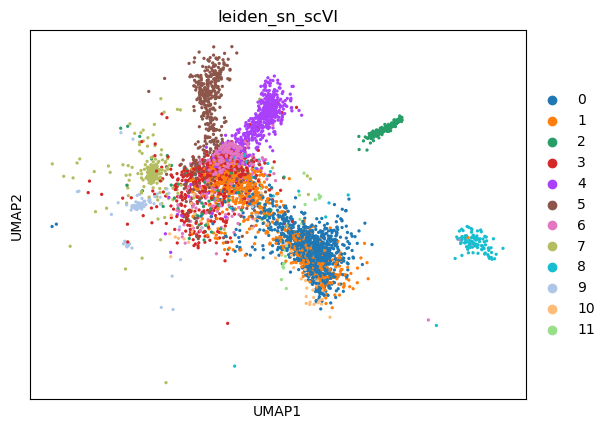

In [77]:
# work on tmp copy
adata_neurons_tmp = sn_neuronal_full_ad.copy()

# recluster with only SN neurons
sc.pp.neighbors(adata_neurons_tmp, use_rep="X_scVI" , n_neighbors=15)
sc.tl.leiden(adata_neurons_tmp, resolution=1.0, key_added="leiden_sn_scVI")

# normalize raw counts (CP10k)
sc.pp.normalize_total(adata_neurons_tmp, target_sum=1e4)

# log-transform
sc.pp.log1p(adata_neurons_tmp)

#score genes on normalized dataset
sc.tl.score_genes(adata_neurons_tmp, existing_markers, score_name="DAcore_score")

#compute mean gene expression / DA score for new clusters
cluster_means = (
    adata_neurons_tmp.obs
    .groupby("leiden_sn_scVI", observed=True)[["DAcore_score"]]
    .mean()
    .sort_values("DAcore_score", ascending=False)
)
print(cluster_means)


sc.pl.umap(adata_neurons_tmp, 
           cmap=sns.cubehelix_palette(dark=0, light=0.9, as_cmap=True),
           color="leiden_sn_scVI")


=== n_neighbors = 10 ===


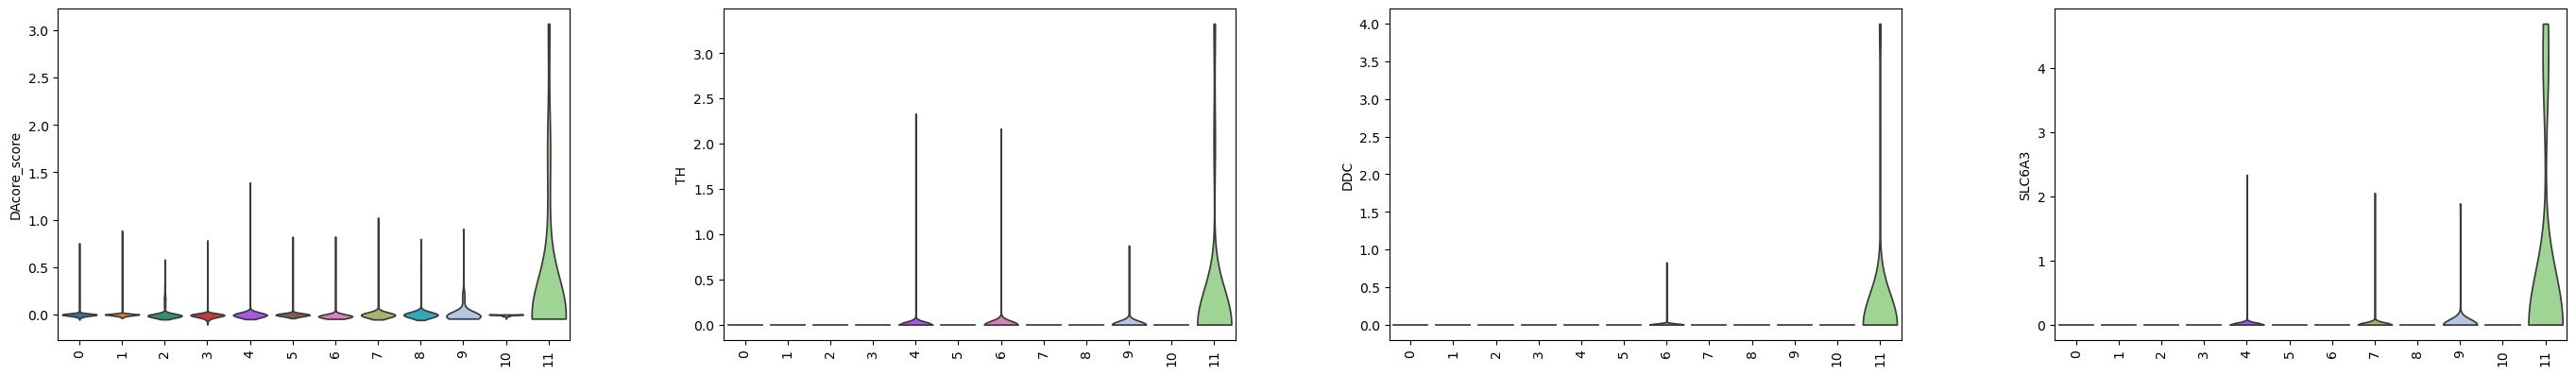


=== n_neighbors = 15 ===


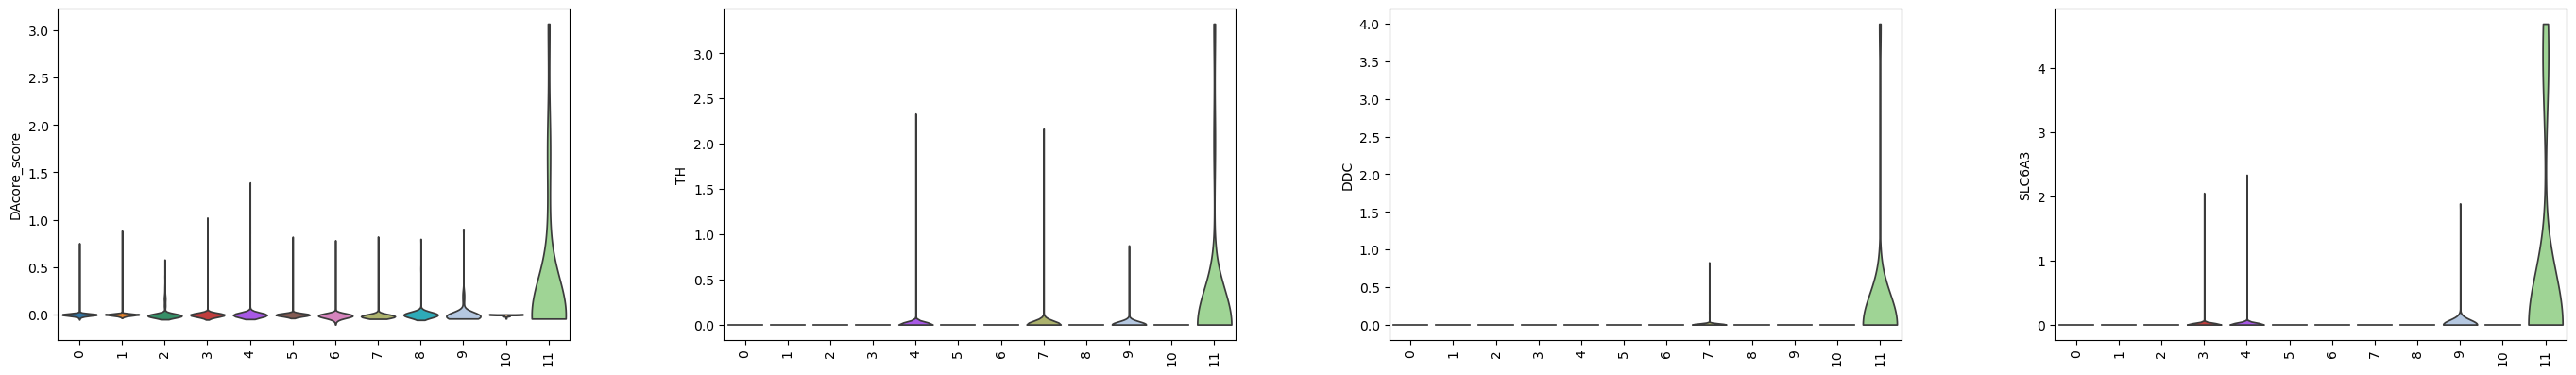


=== n_neighbors = 20 ===


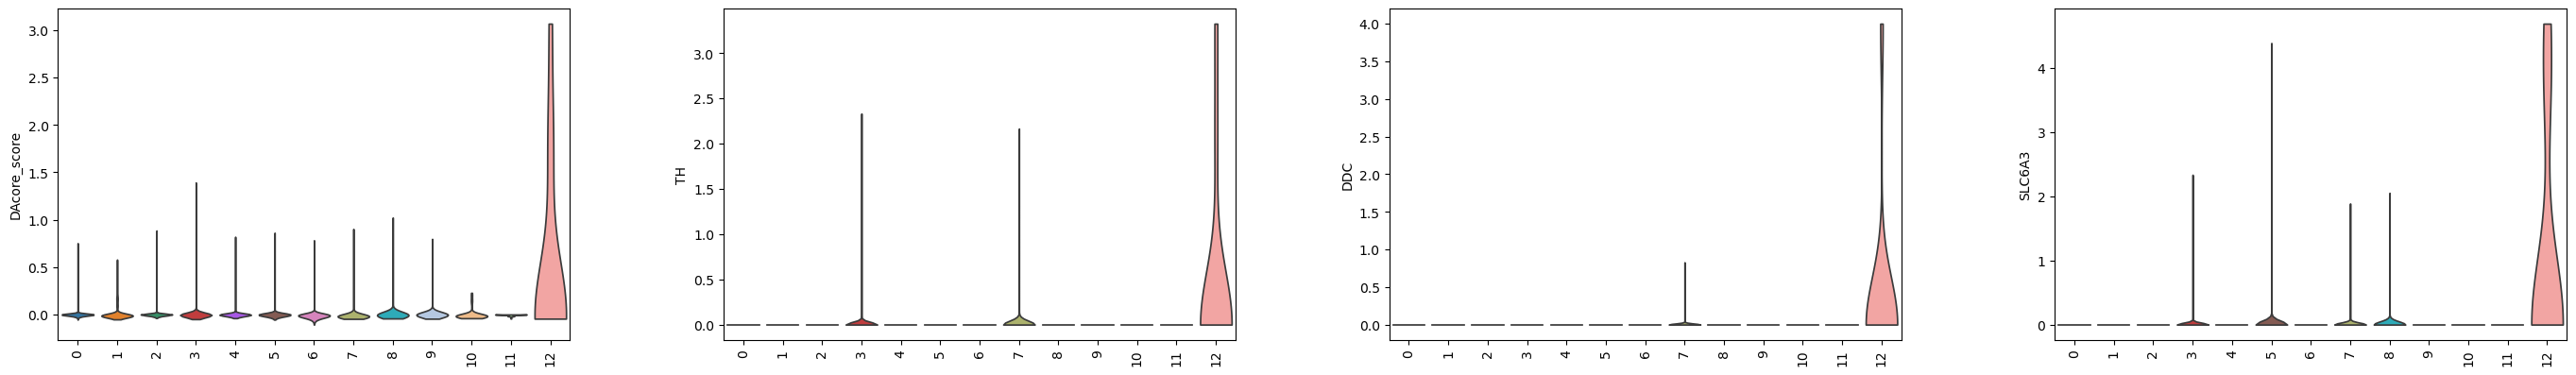

In [56]:
#validating k 
for K in [10, 15, 20]:
    print(f"\n=== n_neighbors = {K} ===")
    sc.pp.neighbors(adata_neurons_tmp, use_rep="X_scVI", n_neighbors=K)
    sc.tl.leiden(adata_neurons_tmp, resolution=1.0, key_added=f"leiden_K{K}")
    
    sc.pl.violin(
        adata_neurons_tmp,
        keys=["DAcore_score", "TH", "DDC", "SLC6A3"],
        groupby=f"leiden_K{K}",
        rotation=90,
        stripplot=False
    )


In [58]:
adata_neurons_tmp.obs["leiden_sn_scVI"].value_counts()


leiden_sn_scVI
0     1002
1      824
2      803
3      601
4      535
5      508
6      438
7      357
8      139
9      100
10      55
11      26
Name: count, dtype: int64

In [74]:
da_cluster = "11"
adata_DA = adata_neurons_tmp[adata_neurons_tmp.obs["leiden_sn_scVI"] == da_cluster].copy()
adata_DA

AnnData object with n_obs × n_vars = 26 × 36601
    obs: 'background_fraction', 'cell_probability', 'cell_size', 'droplet_efficiency', 'n_genes_by_counts', 'total_counts', 'total_counts_rb', 'pct_counts_rb', 'total_counts_mt', 'pct_counts_mt', 'doublet_score', 'sample', 'batch', 'team', 'dataset', 'batch_id', 'S_score', 'G2M_score', 'phase', 'cell_type', 'phenotype', 'rho', 'prob', 'class_name', 'subclass_name', 'supertype_name', '_scvi_batch', '_scvi_labels', 'C_scANVI', 'leiden_res_0.05', 'leiden_res_0.10', 'leiden_res_0.20', 'leiden_res_0.40', 'brain_region', 'brain_region_simple', 'case_id', 'condition_id', 'region_level_1', 'region_level_2', 'leiden_sn_scVI', 'DAcore_score', 'DA_candidate'
    var: 'feature_type', 'genome', 'gene_id', 'mt', 'rb'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'estimator', 'fraction_data_used_for_testing', 'learning_curve_learning_rate_epoch', 'learning_curve_test_epoch', 'learning_curve_train_epoch', 'leiden_res_0.05', 'leiden_res_0.10', 'leiden_res_

26 DA cells too small for subtyping -- will consider this highly confident (Tier 1) 
--> potentially could broaden filter 

## prelimary data visulizations for understanding (ignore)

Groups with no expression: ['Chandelier_1', 'Chandelier_2', 'L2/3 IT_1', 'L2/3 IT_5', 'L2/3 IT_6', 'L2/3 IT_7', 'L2/3 IT_10', 'L2/3 IT_13', 'L4 IT_2', 'L4 IT_3', 'L5 ET_2', 'L5 IT_1', 'L5 IT_2', 'L5 IT_3', 'L5 IT_6', 'L5/6 NP_6', 'L6 CT_2', 'L6 CT_3', 'L6 CT_4', 'L6 IT Car3_1', 'L6 IT Car3_3', 'L6 IT_1', 'L6b_2', 'L6b_3', 'L6b_5', 'L6b_6', 'Lamp5_2', 'Lamp5_4', 'Lamp5_5', 'Lamp5_6', 'Pax6_3', 'Pvalb_1', 'Pvalb_2', 'Pvalb_3', 'Pvalb_10', 'Pvalb_12', 'Pvalb_13', 'Pvalb_15', 'Sncg_1', 'Sncg_2', 'Sncg_3', 'Sncg_4', 'Sncg_5', 'Sncg_6', 'Sncg_8', 'Sst_2', 'Sst_3', 'Sst_4', 'Sst_5', 'Sst_9', 'Sst_11', 'Sst_12', 'Sst_13', 'Sst_20', 'Sst_23', 'Sst_25', 'Vip_1', 'Vip_2', 'Vip_4', 'Vip_5', 'Vip_6', 'Vip_12', 'Vip_13', 'Vip_15', 'Vip_18', 'Vip_19', 'Vip_23']


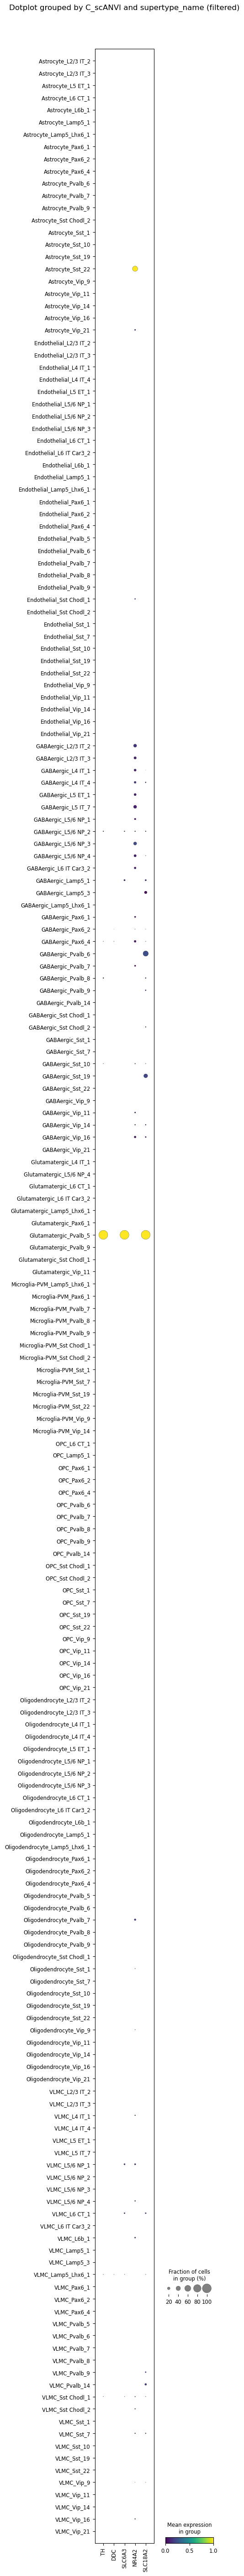

In [62]:
# compute mean expression per group (normalized data)
group_means = (
    adata_neurons_tmp[:, existing_markers]
    .to_df()
    .groupby(adata_neurons_tmp.obs["supertype_name"], observed=True)
    .mean()
)

# find groups with all zero expression
empty_groups = group_means[(group_means == 0).all(axis=1)].index.tolist()
print("Groups with no expression:", empty_groups)

# subset AnnData to exclude those groups
filtered_ad = adata_neurons_tmp[~adata_neurons_tmp.obs["supertype_name"].isin(empty_groups)].copy()

# plot dotplot on filtered object
sc.pl.dotplot(
    filtered_ad,
    var_names=existing_markers,
    groupby=["C_scANVI", "supertype_name"],
    standard_scale="var",
    title="Dotplot grouped by C_scANVI and supertype_name (filtered)",
    cmap="viridis"
)



In [67]:
# # Compute mean expression per group
# df = adata_neurons_tmp[:, existing_markers].to_df()

# # Add grouping columns from obs
# df["C_scANVI"] = adata_neurons_tmp.obs["C_scANVI"].values
# df["supertype_name"] = adata_neurons_tmp.obs["supertype_name"].values

# group_means = df.groupby(["C_scANVI", "supertype_name"], observed=True).mean()
# # Compute number of cells per group
# group_counts = df.groupby(["C_scANVI", "supertype_name"], observed=True).size()

# # Combine into one table
# group_means_table = group_means.reset_index()
# group_means_table["n_cells"] = group_counts.values

# # Build mask: rows where ANY marker gene > 0
# mask = (group_means_table[marker_genes] > 0).any(axis=1)

# # Apply mask
# filtered_table = group_means_table[mask].sort_values(by="n_cells", ascending =False)

# print(filtered_table)

# DAmean_table_filename = (local_data_path / "DA_marker_means.csv")
# group_means_table.to_csv(DAmean_table_filename)


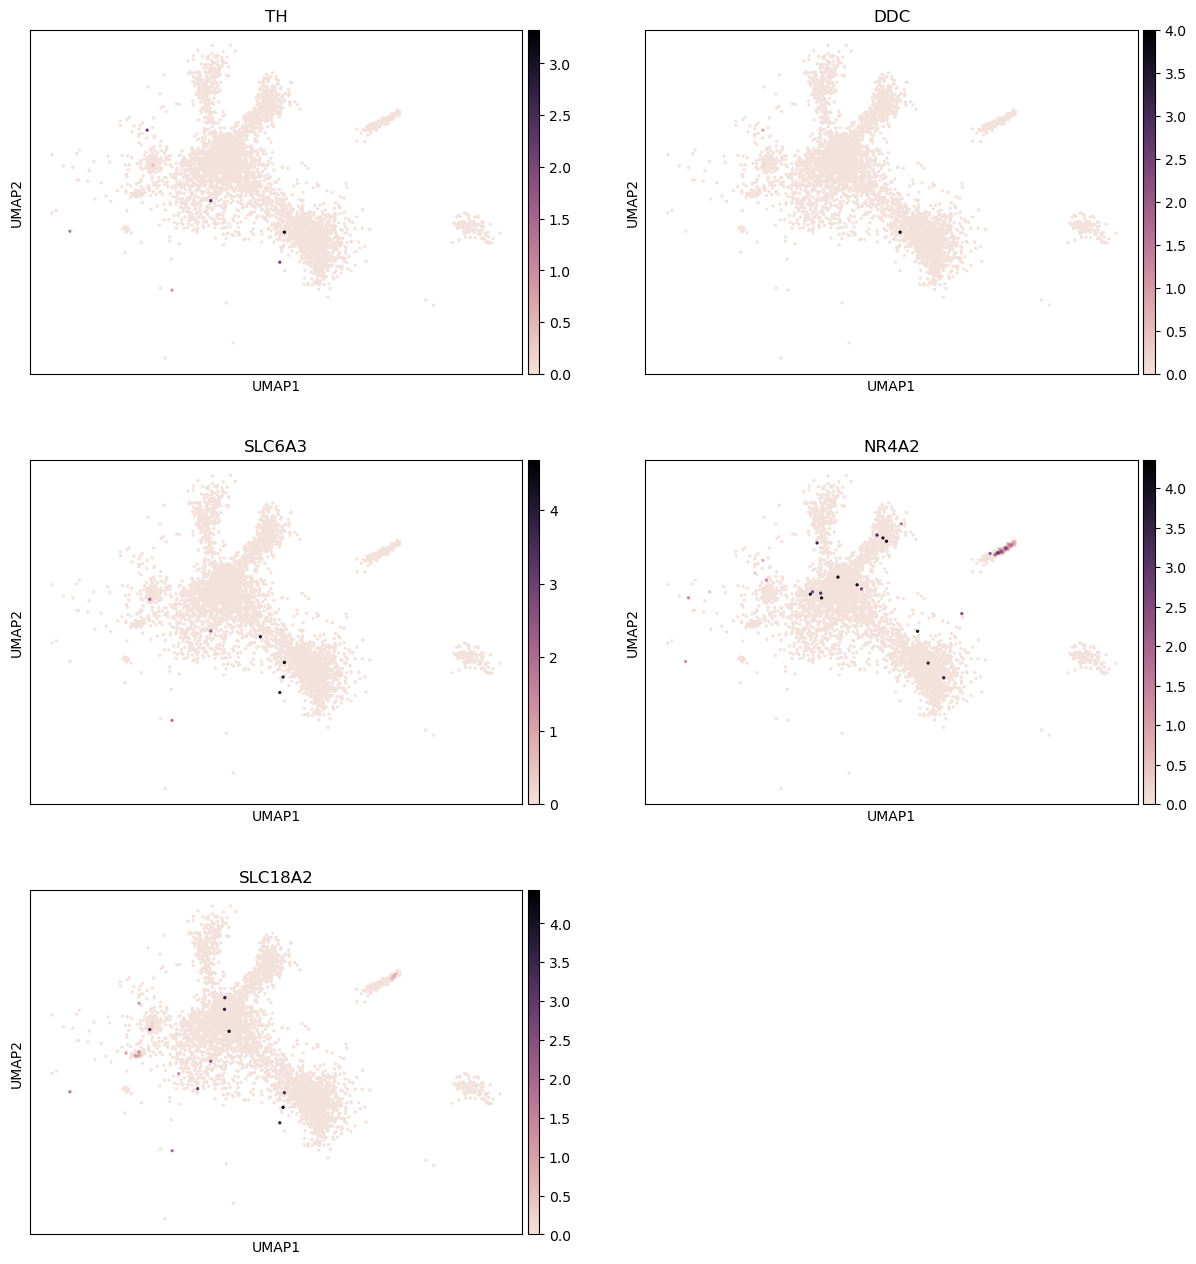

In [68]:
sc.pl.umap(adata_neurons_tmp, 
           color=existing_markers, 
           cmap=sns.cubehelix_palette(dark=0, light=0.9, as_cmap=True),
          ncols = 2,
          )

In [69]:
# Extract expression matrix for these genes
expr = adata_neurons_tmp[:, existing_markers].X

# Convert sparse to dense if needed
if not isinstance(expr, np.ndarray):
    expr = expr.toarray()

# Count how many markers are expressed (>0) per cell
marker_counts = (expr > 0).sum(axis=1)

# Gate: cells with at least 2 markers expressed
mask = marker_counts >= 2
# Subset AnnData
adata_DA = adata_neurons_tmp[mask].copy()

# Annotate in obs
adata_neurons_tmp.obs["DA_candidate"] = mask

# Print how many cells satisfy this
print("Number of cells with ≥ 2 markers expressed:", mask.sum())

# Print also how many total cells
print("Total cells:", len(marker_counts))
print("Fraction:", mask.sum() / len(marker_counts))

Number of cells with ≥ 2 markers expressed: 10
Total cells: 5388
Fraction: 0.001855976243504083


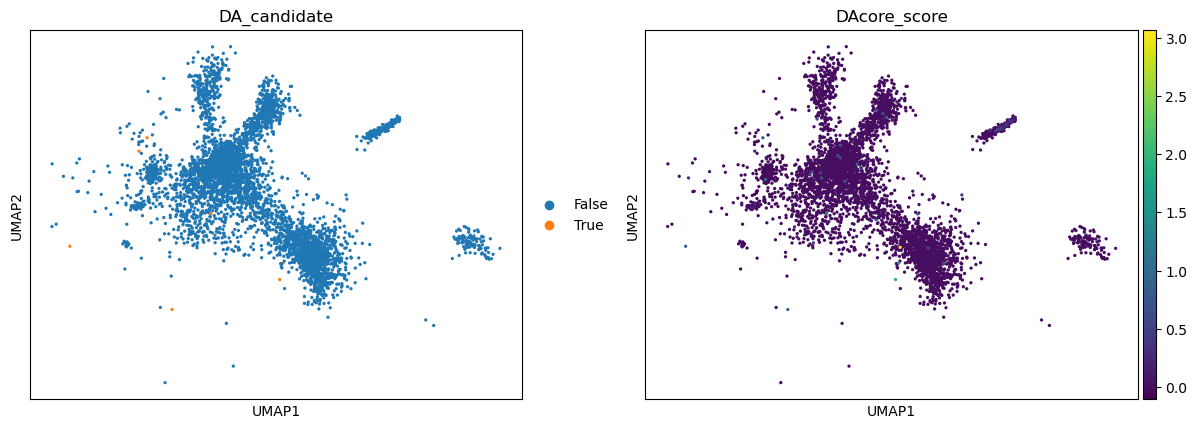

In [71]:
sc.pl.umap(
    adata_neurons_tmp,
    color=["DA_candidate", "DAcore_score"]
)


In [72]:
unique, counts = np.unique(marker_counts, return_counts=True)
for u, c in zip(unique, counts):
    print(f"{u} markers: {c} cells")


0 markers: 5246 cells
1 markers: 132 cells
2 markers: 4 cells
3 markers: 5 cells
4 markers: 1 cells
